In [27]:
import pandas as pd
import numpy as np
import statistics
data = pd.read_csv('wine_cleared.csv', index_col=0)
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import matthews_corrcoef
import seaborn as sns
import re

In [28]:
data['price_round'] = data['price'].round().astype(int)


In [29]:
regex = '\d{4}' # регулярное выражение для нахождения чисел
data['year'] = data['title'].str.findall(regex).str.get(0)

In [30]:
data['is_usa'] = data['country'].apply(lambda x: 1 if x == 'US' else 0)
data['is_france'] = data['country'].apply(lambda x: 1 if x == 'France' else 0)
data['is_italy'] = data['country'].apply(lambda x: 1 if x == 'Italy' else 0)

In [31]:
data['old_wine'] = data['year'].apply(lambda x: 1 if float(x) < 2010 else 0)

In [32]:
regex = '\((.*?)\)'
data['locality'] = data['title'].str.findall(regex).str.get(0)

In [33]:
country_population = pd.read_csv('country_population.csv', sep=';')
country_area = pd.read_csv('country_area.csv', sep=';')

In [34]:
data = data.join(country_population.set_index('country'), on='country')
data = data.join(country_area.set_index('country'), on='country')

In [35]:
data[data['title'] == 'Gård 2014 Grand Klasse Reserve Lawrence Vineyards Viognier (Columbia Valley (WA))']

,country,description,designation,points,price,province,region_1,taster_name,taster_twitter_handle,title,...,winery,price_round,year,is_usa,is_france,is_italy,old_wine,locality,population,area
94,US,"Barrel notes are prominent, with aromas of Cre...",Grand Klasse Reserve Lawrence Vineyards,88,22.0,Washington,Columbia Valley (WA),Sean P. Sullivan,@wawinereport,Gård 2014 Grand Klasse Reserve Lawrence Vineya...,...,Gård,22,2014,1,0,0,0,Columbia Valley (WA,"333,022,386",9372610.0


In [36]:
data['year'] = pd.to_datetime(data['year'], errors = 'coerce')

In [37]:
data['years_diff'] = (pd.to_datetime('2022-01-12') - data['year']).dt.days

In [38]:
data['years_diff'].max()

98627.0

In [39]:
import category_encoders as ce
ord_encoder = ce.OrdinalEncoder()
year_col = ord_encoder.fit_transform(data['year'])
data = pd.concat([data, year_col], axis=1)

In [40]:
encoder = ce.OneHotEncoder(cols=['taster_name'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['taster_name'])
data = pd.concat([data, type_bin], axis=1)

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129972 entries, 0 to 129970
Data columns (total 38 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   country                         129909 non-null  object        
 1   description                     129972 non-null  object        
 2   designation                     129972 non-null  object        
 3   points                          129972 non-null  int64         
 4   price                           129972 non-null  float64       
 5   province                        129909 non-null  object        
 6   region_1                        129972 non-null  object        
 7   taster_name                     129972 non-null  object        
 8   taster_twitter_handle           129972 non-null  object        
 9   title                           129972 non-null  object        
 10  variety                         129971 non-null  object      

In [42]:
from sklearn import preprocessing
r_scaler = preprocessing.RobustScaler()
data_new = data['price'].values.reshape(-1,1)
df_r = r_scaler.fit_transform(data_new)

In [43]:
data['price']

0         35.363389
1         15.000000
2         14.000000
3         13.000000
4         65.000000
            ...    
129966    28.000000
129967    75.000000
129968    30.000000
129969    32.000000
129970    21.000000
Name: price, Length: 129972, dtype: float64

In [44]:
s_scaler = preprocessing.StandardScaler()
data['price'] = s_scaler.fit_transform(data[['price']])

In [45]:
data = pd.DataFrame(data)

KeyError: "['is_usa' 'is_france' 'is_italy' 'price_round'] not found in axis"

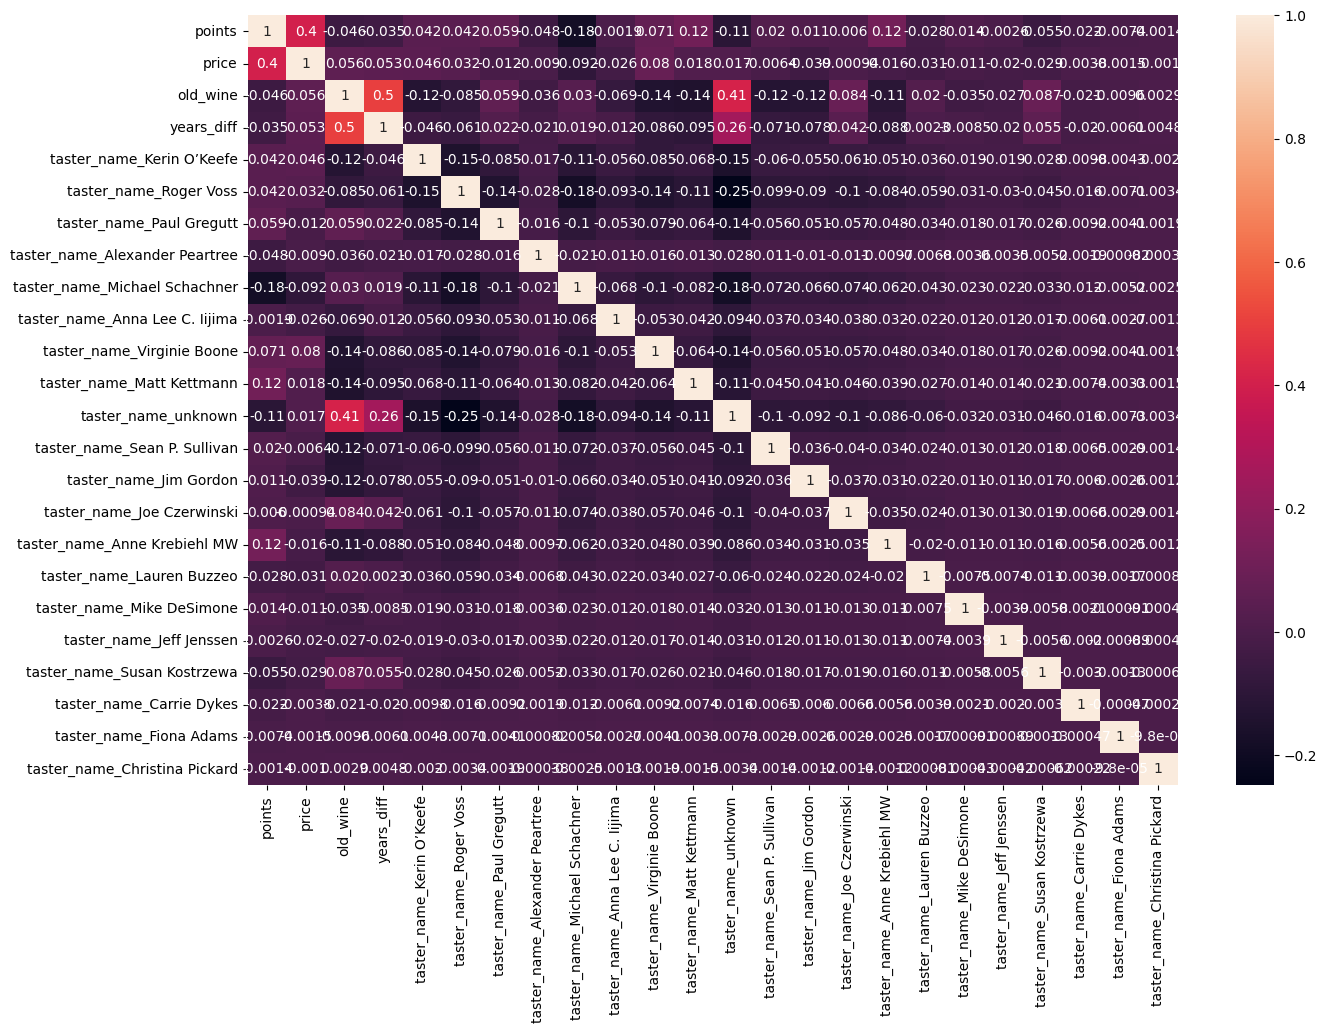

In [48]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(data.corr(numeric_only=True), annot=True, ax = ax)

# Удалим самые сильно скоррелированные пары
data = data.drop(['is_usa', 'is_france', 'is_italy', 'price_round'], axis=1)

# Проверяем, что сильно скоррелированных признаков не осталось
sns.heatmap(data.corr(numeric_only=True), annot=True, linewidths=.5, ax=ax)